In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
import datetime

import warnings
warnings.filterwarnings('ignore')
os.chdir("C:/Users/danil/Desktop/ИТМО/Лаба/Дата для анализа спроса")

In [3]:
# данные для нулевой пиццерии с агрегацией на весь день
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']
df

,value
2022-01-01,651
2022-01-02,626
2022-01-03,336
2022-01-04,308
2022-01-05,337
...,...
2023-09-26,466
2023-09-27,513
2023-09-28,563
2023-09-29,699


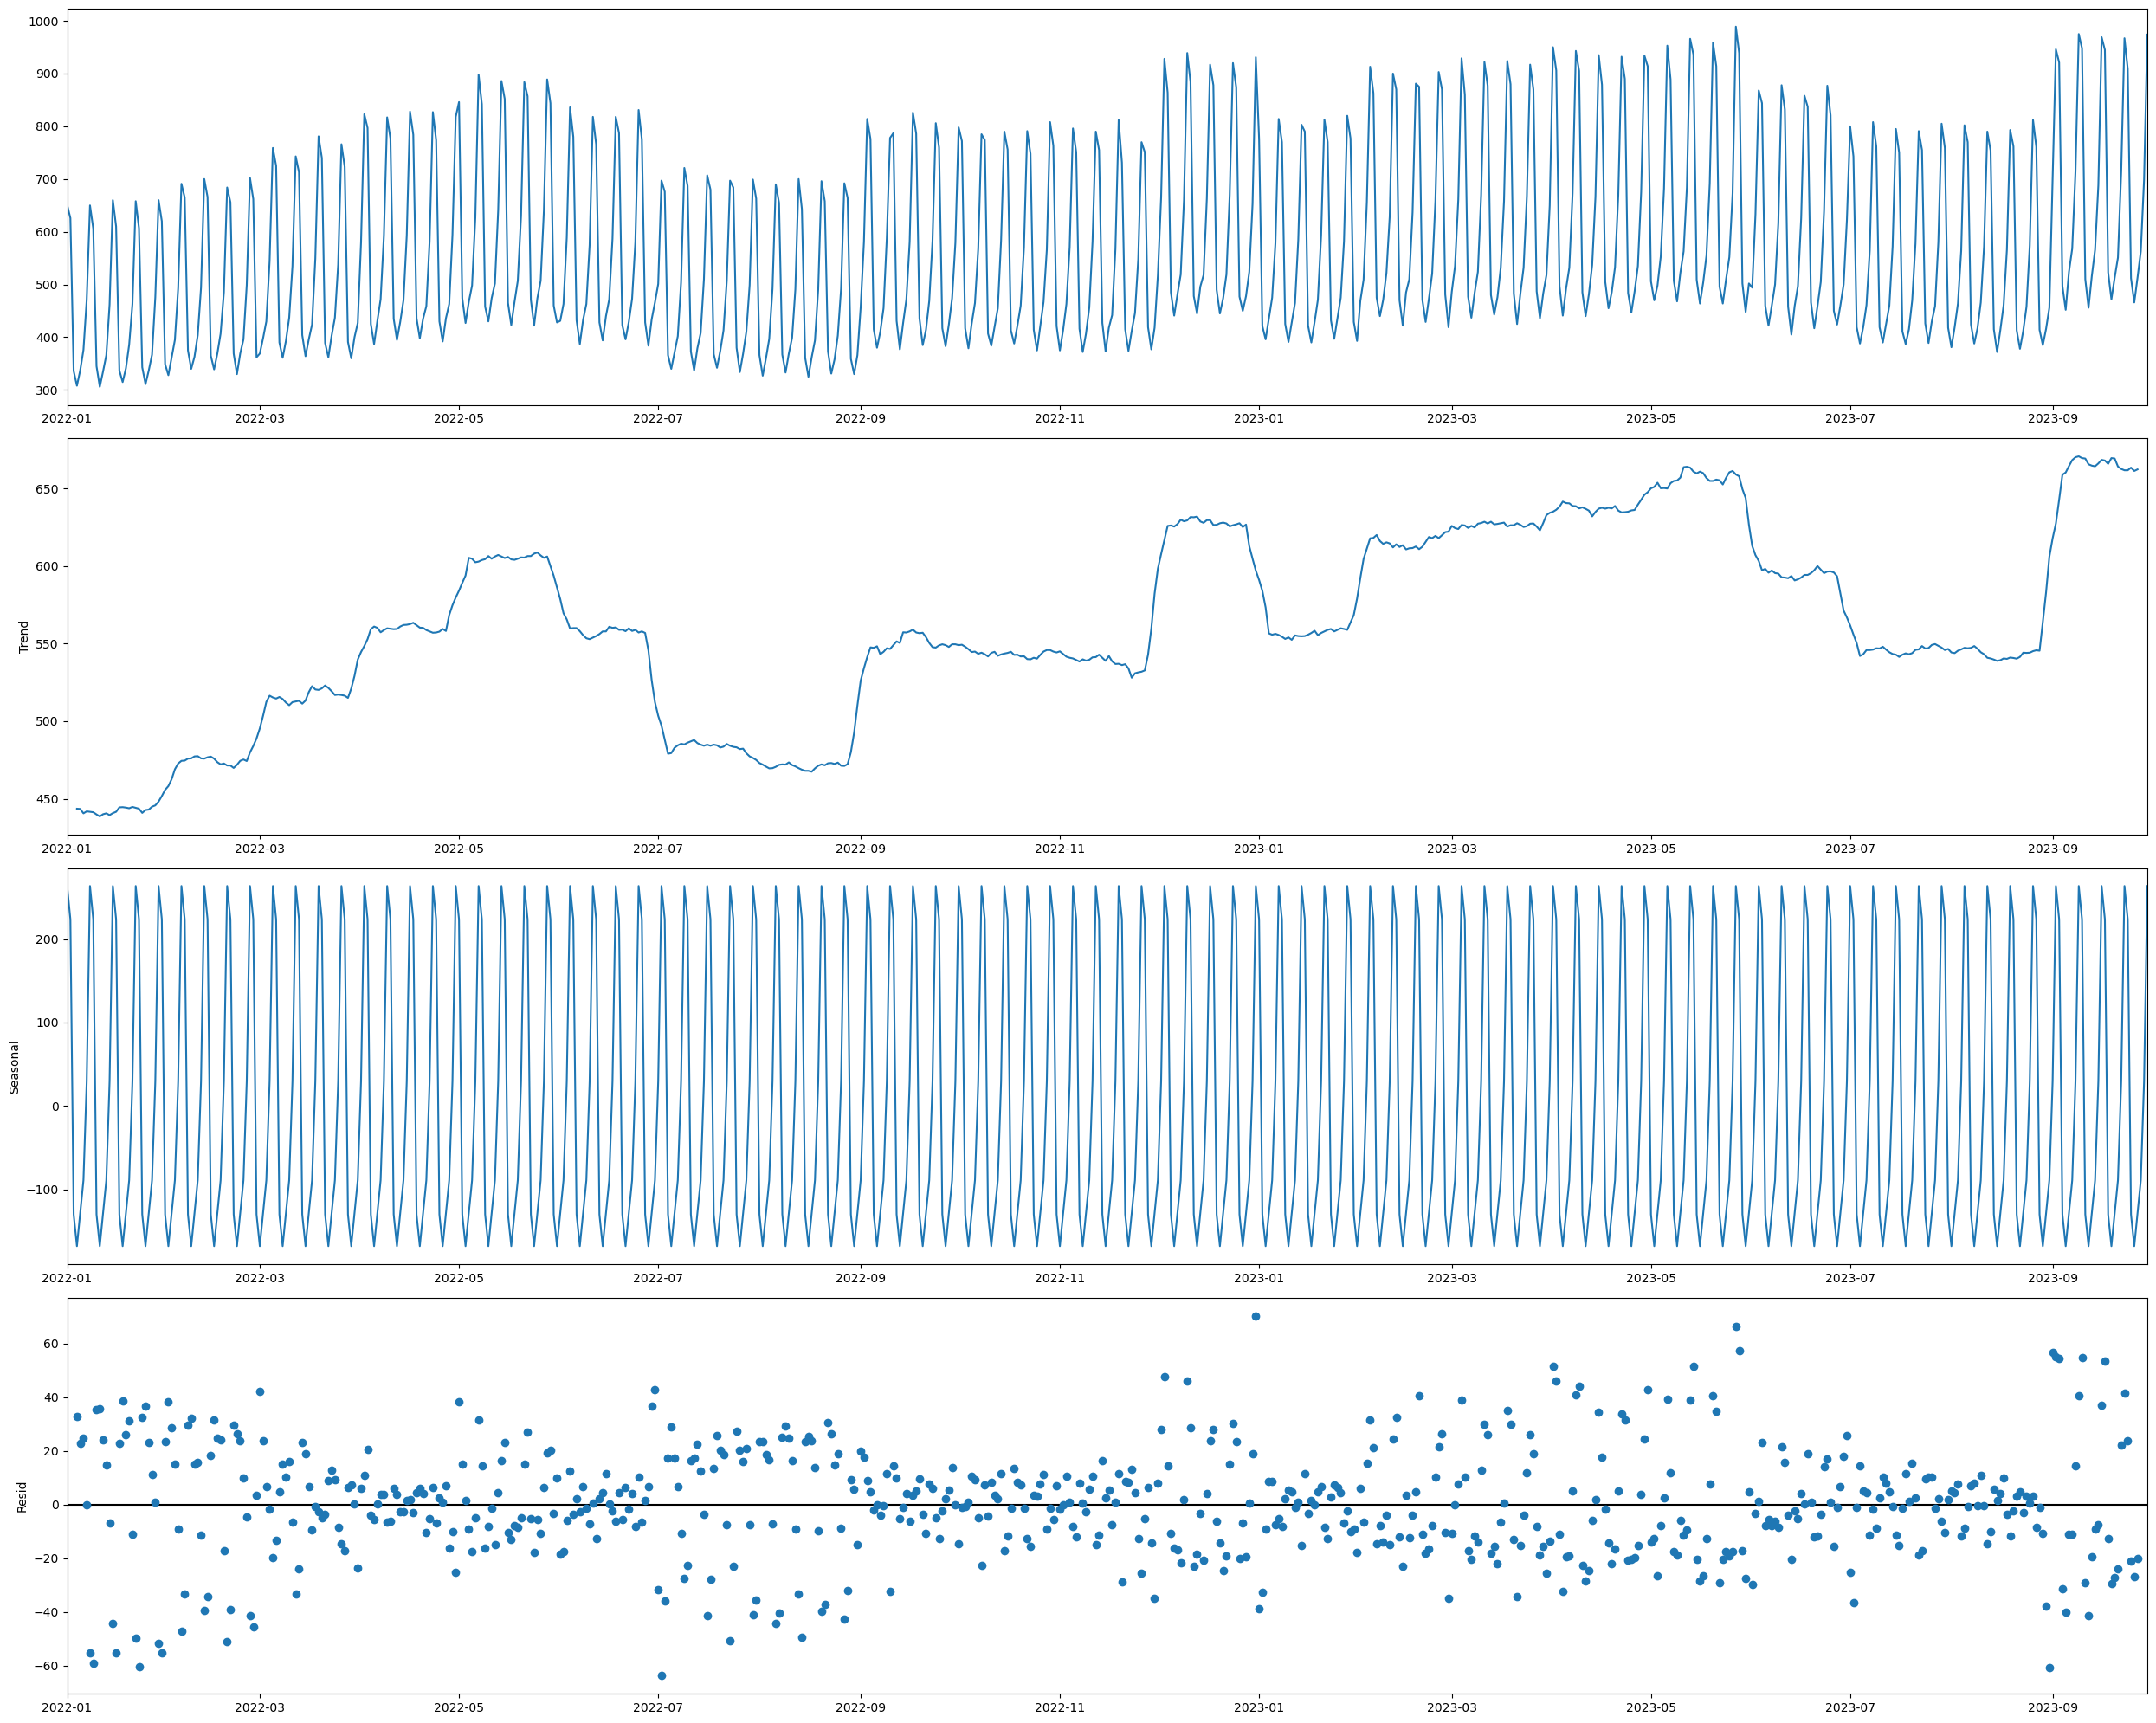

In [4]:
# разложение ряда на тренд, сезонную часть и остатки
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(df)
plt.rc("figure", figsize=(25,20))
resplot = res.plot()

In [5]:
# Тест Дики-Фуллера для доказательства нестационарности ряда
from statsmodels.tsa import stattools

df_stat = stattools.adfuller(df)

print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f\ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[4]))

if df_stat[0] > df_stat[4]['5%']:
    print('Есть единичные корни - ряд нестационарный') # 100% верно
else:
    print('Единичных корней нет, ряд стационарен') # не всегда верно

The Augmented Dickey-Fuller test statistic -2.348911, 
pvalue: 0.16
critical values: {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}
Есть единичные корни - ряд нестационарный


In [6]:
df['value'].shift(1)

2022-01-01      NaN
2022-01-02    651.0
2022-01-03    626.0
2022-01-04    336.0
2022-01-05    308.0
              ...  
2023-09-26    512.0
2023-09-27    466.0
2023-09-28    513.0
2023-09-29    563.0
2023-09-30    699.0
Freq: D, Name: value, Length: 638, dtype: float64

In [7]:
for i in range(1, 8):
    df[f"lag_{i}"] = df['value'].shift(i)

In [8]:
df.dropna(inplace=True)
df.head()

,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2022-01-08,650,471.0,376.0,337.0,308.0,336.0,626.0,651.0
2022-01-09,606,650.0,471.0,376.0,337.0,308.0,336.0,626.0
2022-01-10,345,606.0,650.0,471.0,376.0,337.0,308.0,336.0
2022-01-11,306,345.0,606.0,650.0,471.0,376.0,337.0,308.0
2022-01-12,335,306.0,345.0,606.0,650.0,471.0,376.0,337.0


In [9]:
# Делаю модель линейной регрессии на временных лагах
Train = df.loc[:'08.31.2023']
Test = df.loc['09.01.2023':]

Train.shape, Test.shape

((601, 8), (30, 8))

In [10]:
X_train = Train.drop('value', axis=1)
y_train = Train['value']

X_test = Test.drop('value', axis=1)
y_test = Test['value']

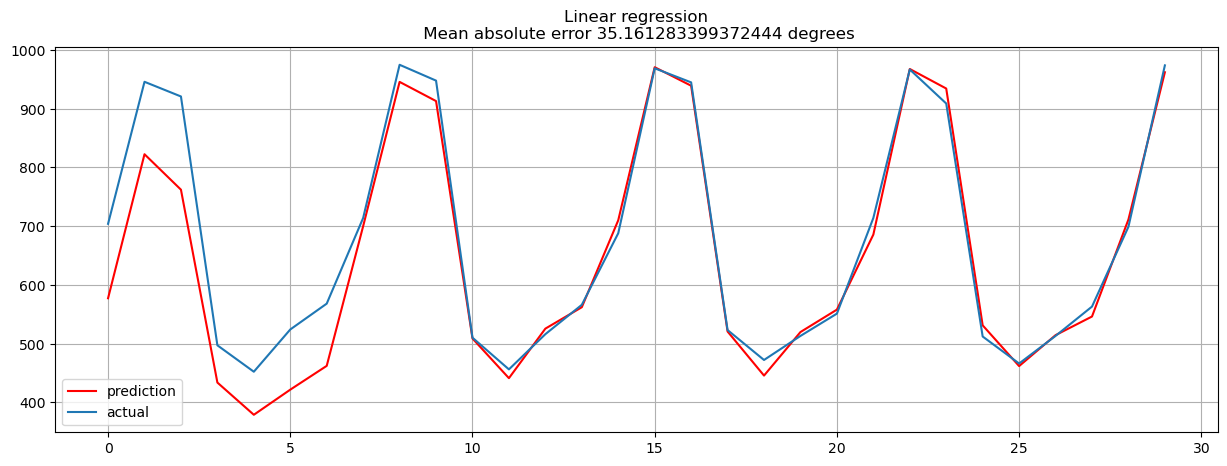

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [12]:
# добавляю в модель линейной регрессии кросс-валилидацию на временных рядах
from sklearn.model_selection import TimeSeriesSplit

y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_error(preds, y_test))

np.mean(errors)

18.29449627286052

Среднее по месяцам и годам

Решил добавить это значение в модель и посмотреть на изменение MAE (средней абсолютной ошибки)

In [13]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [14]:
data = df.copy()

df["month"] = df.index.month
df["year"] = df.index.year

df.head()

,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month,year
2022-01-08,650,471.0,376.0,337.0,308.0,336.0,626.0,651.0,1,2022
2022-01-09,606,650.0,471.0,376.0,337.0,308.0,336.0,626.0,1,2022
2022-01-10,345,606.0,650.0,471.0,376.0,337.0,308.0,336.0,1,2022
2022-01-11,306,345.0,606.0,650.0,471.0,376.0,337.0,308.0,1,2022
2022-01-12,335,306.0,345.0,606.0,650.0,471.0,376.0,337.0,1,2022


In [15]:
code_mean(df, "month", "value")

{1: 510.76363636363635,
 2: 544.5178571428571,
 3: 562.1935483870968,
 4: 613.1666666666666,
 5: 621.9354838709677,
 6: 571.75,
 7: 526.5645161290323,
 8: 495.43548387096774,
 9: 612.4333333333333,
 10: 555.0322580645161,
 11: 528.2333333333333,
 12: 634.9354838709677}

In [16]:
code_mean(df, "year", "value")

{2022: 533.4329608938548, 2023: 604.2967032967033}

In [17]:
def preprocess_data(data, lag_start=1, lag_end=8, date_cut='31.05.2023'):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['value'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.loc[:date_cut], "month", "value").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)
    

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:date_cut].drop(["value"], axis=1)
    y_train = data.loc[:date_cut]["value"]
    X_test = data.loc['09.01.2023':].drop(["value"], axis=1)
    y_test = data.loc['09.01.2023':]["value"]

    return X_train, X_test, y_train, y_test

In [18]:
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']

In [19]:
X_train, X_test, y_train, y_test = preprocess_data(df)

X_train.shape, X_test.shape

((509, 8), (30, 8))

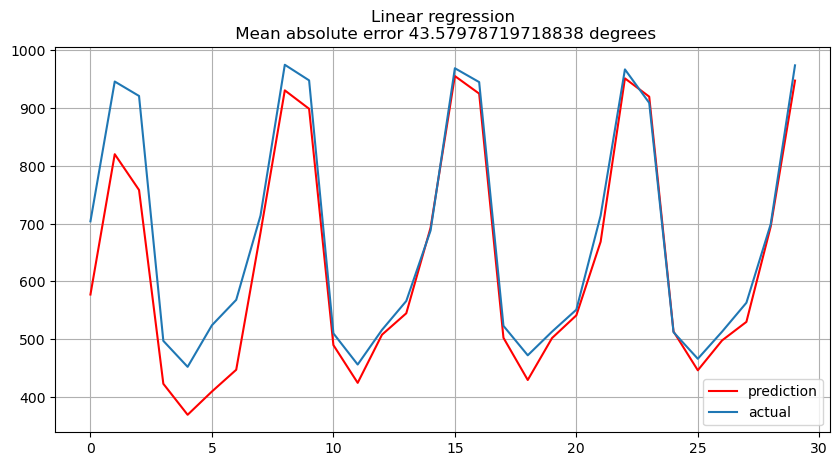

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [21]:
from sklearn.model_selection import TimeSeriesSplit

y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_error(preds, y_test))

np.mean(errors)

# по итогу ошибки стали даже больше 

25.465776701745977

ETNA

Тинькоффская библиотека для прогнозирования

In [22]:
import etna
from etna.datasets.tsdataset import TSDataset
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df['date'] = df.index
df.index = range(len(df))
df.columns = ['value', 'date']
df

,value,date
0,651,2022-01-01
1,626,2022-01-02
2,336,2022-01-03
3,308,2022-01-04
4,337,2022-01-05
...,...,...
633,466,2023-09-26
634,513,2023-09-27
635,563,2023-09-28
636,699,2023-09-29


In [23]:
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["value"]
df.drop(columns=["date", "value"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2022-01-01,651,main
1,2022-01-02,626,main
2,2022-01-03,336,main
3,2022-01-04,308,main
4,2022-01-05,337,main


In [24]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2022-01-01,651
2022-01-02,626
2022-01-03,336
2022-01-04,308
2022-01-05,337


In [25]:
ts = TSDataset(df, freq="D")

ts.head()

# все эти манипуляции нужны для работы

segment,main
feature,target
timestamp,
2022-01-01,651
2022-01-02,626
2022-01-03,336
2022-01-04,308
2022-01-05,337


In [26]:
train_ts, test_ts = ts.train_test_split(
    train_start="2022-01-01",
    train_end="2023-08-31",
    test_start="2023-09-01",
    test_end="2023-09-30",
)

In [27]:
HORIZON = 30 # горизонт прогнозирования

from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

# Обучаем этот вид модели
model1 = NaiveModel(lag=5)

model1.fit(train_ts)

# ПРогноз
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)

forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

In [28]:
from etna.metrics import MAE

mae = MAE()
mae(y_true=test_ts, y_pred=forecast_ts)

{'main': 259.7}

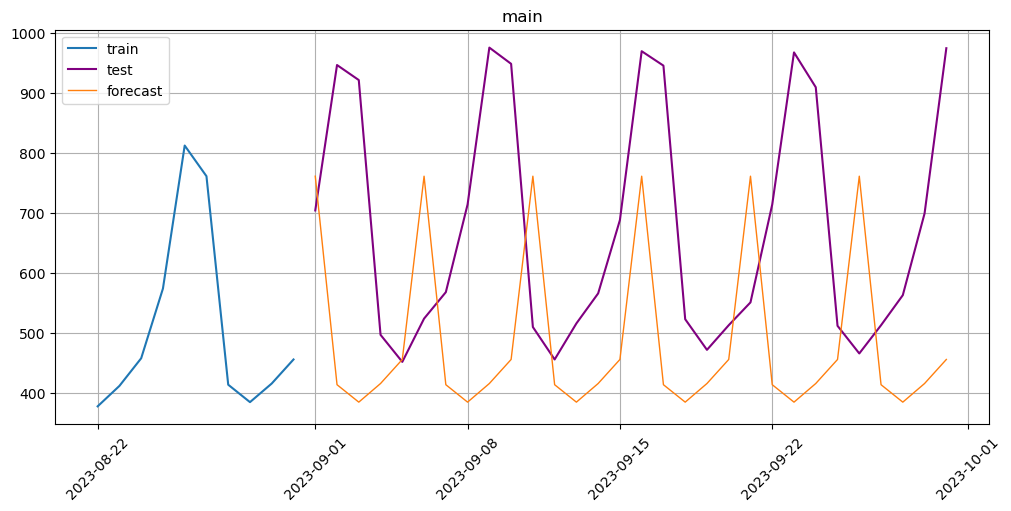

In [29]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [30]:
from etna.models import ProphetModel

model2 = ProphetModel()

model2.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)

00:16:15 - cmdstanpy - INFO - Chain [1] start processing
00:16:16 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
mae(y_true=test_ts, y_pred=forecast_ts)

{'main': 161.65670036775276}

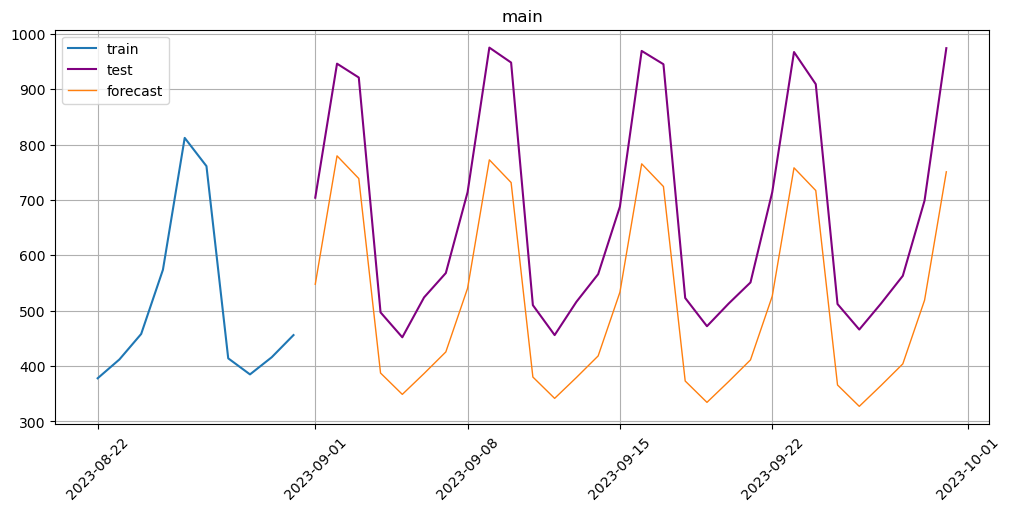

In [32]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [33]:
# модель с пайплайном в виде трансформации ряда и применения модели
# пайплайн с линейной регрессией
from etna.pipeline import Pipeline
from etna.metrics import MAE, SMAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

pipe = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=LinearPerSegmentModel(),
    horizon=3
)

In [34]:
metrics, forecast, _ = pipe.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

,segment,MAE,SMAPE,fold_number
0,main,16.499373,2.666056,0
0,main,10.873338,2.256817,1
0,main,22.103264,2.433260,2
0,main,25.353160,5.300686,3
0,main,6.289918,1.000594,4


In [35]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

16.223810581878293

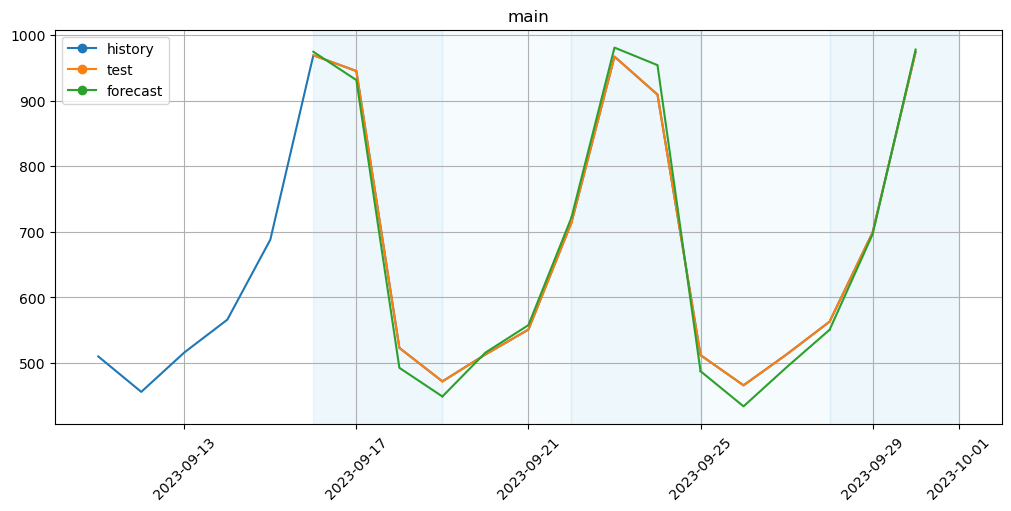

In [36]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df=forecast, ts=ts, history_len=5)

In [37]:
# такие же трансформации, где мы разбиваем ряд на составляющие, а потом добавляем лаги, только теперь используем catboost
pipe2 = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=CatBoostMultiSegmentModel(n_estimators=1000, learning_rate=0.01),
    horizon=3
)
metrics, forecast, _ = pipe2.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

,segment,MAE,SMAPE,fold_number
0,main,15.184759,2.409456,0
0,main,8.639394,1.800184,1
0,main,24.614208,2.787299,2
0,main,24.812034,5.179243,3
0,main,6.433493,1.048764,4


In [38]:
mae_value = metrics.mean().to_dict()["MAE"]

mae_value

15.93677770846135

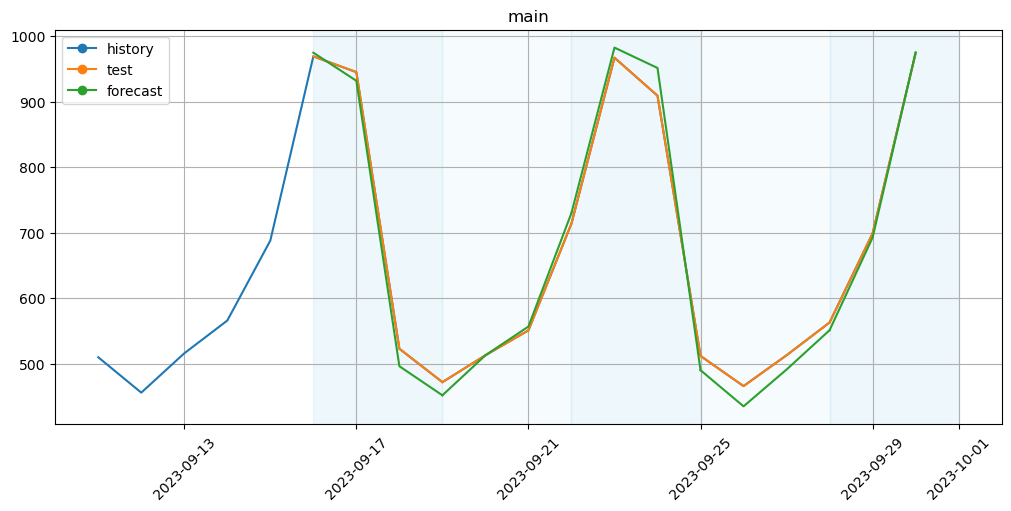

In [39]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=5)